In [1]:
import pandas as pd
import networkx as nx
from node2vec import Node2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

## Graph Analysis

In [2]:
# load data
df = pd.read_csv('data/wikispeedia_paths-and-graph/links.tsv', sep='\t', comment='#', header=None, names=['origin', 'destination'])
print(df)

# Create directed graph
G = nx.from_pandas_edgelist(df, source='origin', target='destination', create_using=nx.DiGraph())

                                  origin     destination
0       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in            Bede
1       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Columba
2       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in  D%C3%A1l_Riata
3       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in   Great_Britain
4       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in         Ireland
...                                  ...             ...
119877                              Zulu    South_Africa
119878                              Zulu       Swaziland
119879                              Zulu  United_Kingdom
119880                              Zulu          Zambia
119881                              Zulu        Zimbabwe

[119882 rows x 2 columns]


### Get the graph embedding for metric use 

In [3]:
# Initialize Node2Vec model
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities:   0%|          | 0/4592 [00:00<?, ?it/s]

In [4]:
# Fit and generate node embeddings
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract embeddings as a dictionary, with nodes as keys and embeddings as values
embeddings = {node: model.wv[node] for node in G.nodes()}

In [7]:
# Convert embeddings dictionary to a list for dimensionality reduction
embedding_values = list(embeddings.values())
node_names = list(embeddings.keys())

# Reduce dimensions to 2D using PCA
pca = PCA(n_components=2)
embedding_2d = pca.fit_transform(embedding_values)

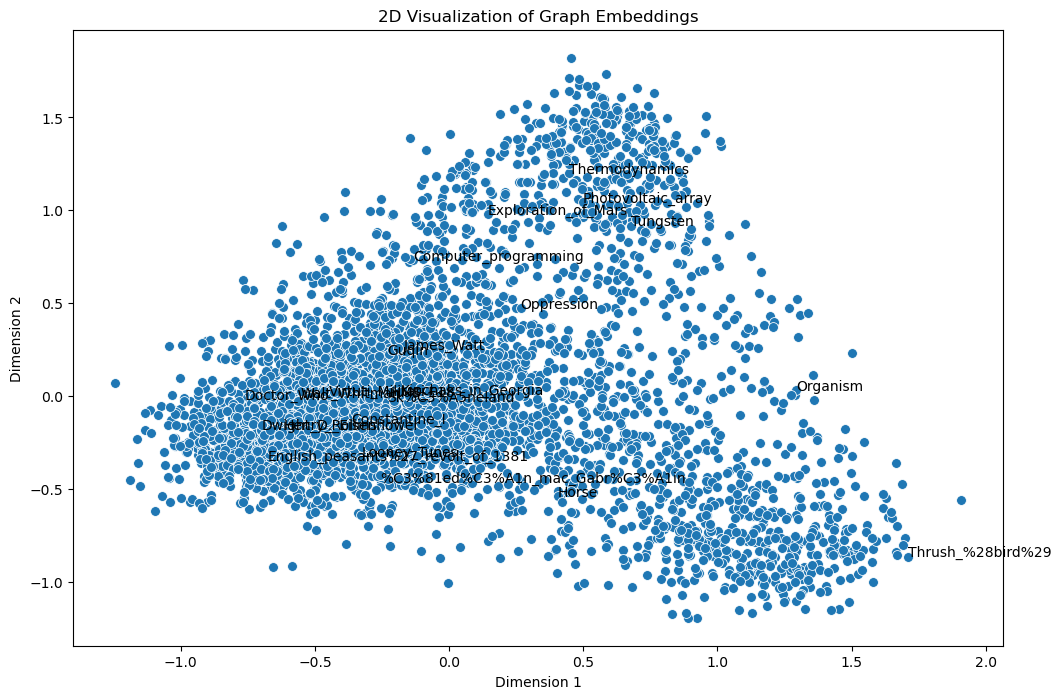

In [27]:
# Create a DataFrame for plotting
plot_df = pd.DataFrame(embedding_2d, columns=['x', 'y'])
plot_df['node'] = node_names

# Plot using seaborn for better aesthetics
plt.figure(figsize=(12, 8))
sns.scatterplot(x='x', y='y', data=plot_df, s=50, marker='o')

# Optionally, annotate a few nodes for context
for i, node in enumerate(plot_df['node']):
    if i % 200 == 0:  # Adjust this to annotate every nth node or specific nodes
        plt.text(plot_df['x'][i], plot_df['y'][i], node, fontsize=10)

plt.title('2D Visualization of Graph Embeddings')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

### Graph Statistics Analysis

In [10]:
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()
density = nx.density(G)

print(f'Number of nodes: {num_nodes}, Number of edges: {num_edges}, Density: {density}')

Number of nodes: 4592, Number of edges: 119882, Density: 0.005686496910710776


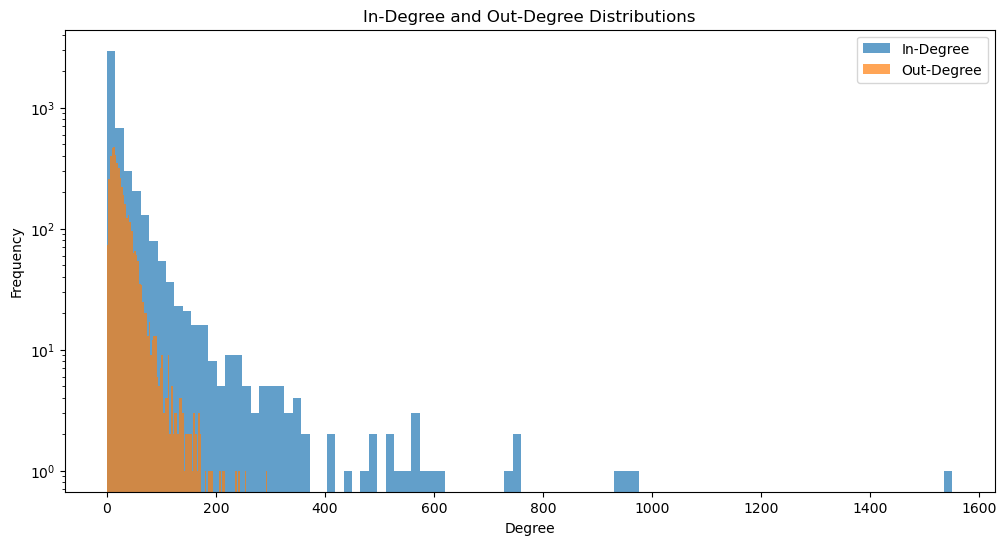

In [15]:
# Degree distributions
in_degrees = dict(G.in_degree())  
out_degrees = dict(G.out_degree()) 

plt.figure(figsize=(12, 6))
plt.hist(in_degrees.values(), bins=100, alpha=0.7, label='In-Degree')
plt.hist(out_degrees.values(), bins=100, alpha=0.7, label='Out-Degree')
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.yscale('log')
plt.legend()
plt.title("In-Degree and Out-Degree Distributions")
plt.show()

In [23]:
# Is the graph connected? 

num_weakly_connected_components = nx.number_weakly_connected_components(G)
largest_weakly_connected_component = max(nx.weakly_connected_components(G), key=len)

print(f"Number of weakly connected components: {num_weakly_connected_components}, Largest weakly connected component size: {len(largest_weakly_connected_component)}")

Number of weakly connected components: 2, Largest weakly connected component size: 4589


#### So there are only 3 nodes out of this component

In [25]:
# Path analysis in largest component

largest_cc = G.subgraph(largest_weakly_connected_component).copy()

avg_shortest_path_length = nx.average_shortest_path_length(largest_cc.to_undirected())
diameter = nx.diameter(largest_cc.to_undirected())

print(f"Average shortest path length: {avg_shortest_path_length}, Diameter: {diameter}")

Average shortest path length: 2.5253455678384857, Diameter: 5


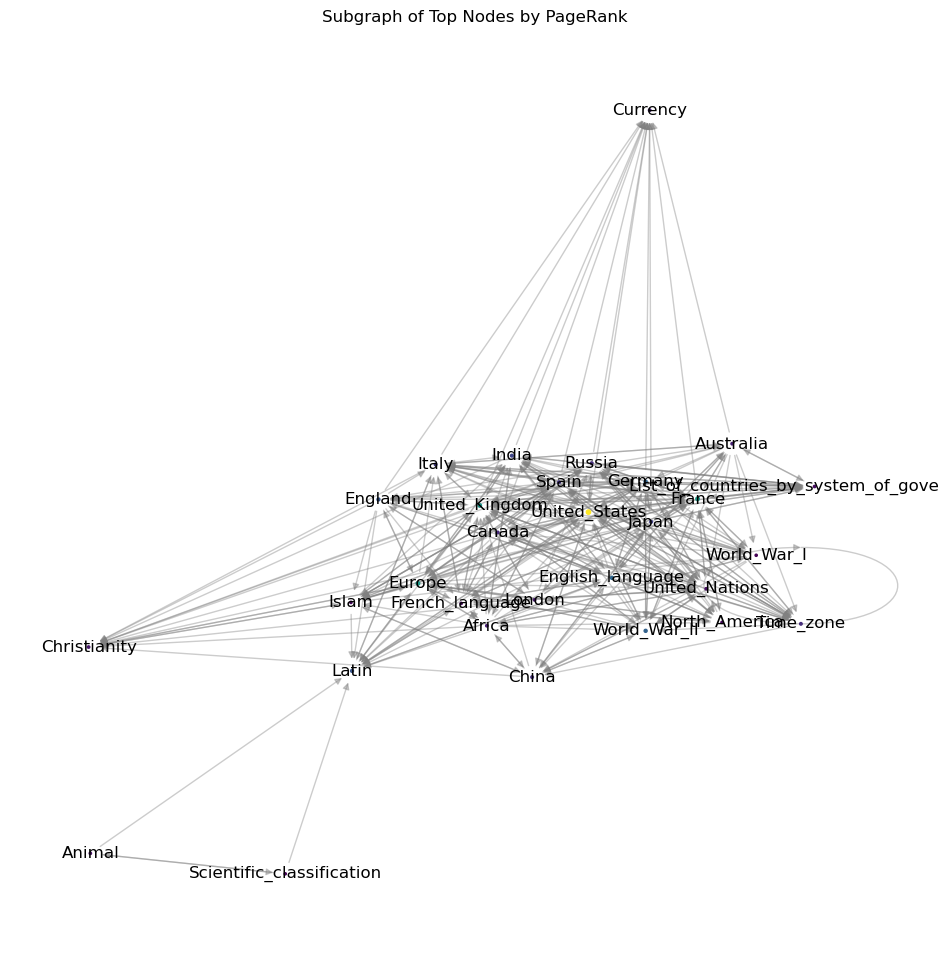

In [31]:
pagerank = nx.pagerank(G)

# Select the top 30 nodes using PageRank score and create a subgraph
top_nodes = sorted(pagerank, key=pagerank.get, reverse=True)[:30]
G_top_pagerank = G.subgraph(top_nodes).copy()

# Plot the subgraph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G_top_pagerank) 
node_sizes = [pagerank[node] * 1000 for node in G_top_pagerank]
node_colors = [pagerank[node] for node in G_top_pagerank]

# Plot nodes
nx.draw_networkx_nodes(
    G_top_pagerank,
    pos=pos,
    node_size=node_sizes,
    node_color=node_colors,
    cmap=plt.cm.viridis
)

# Plot edges 
nx.draw_networkx_edges(
    G_top_pagerank,
    pos=pos,
    edge_color="gray",
    alpha=0.4  # Make edges semi-transparent
)

# Plot labels
nx.draw_networkx_labels(
    G_top_pagerank,
    pos=pos,
    font_size=12,
    font_color="black"  # Set font color to black for better readability
)

plt.title("Subgraph of Top Nodes by PageRank")
plt.axis("off") 
plt.show()


## Human navigation paths analysis

In [32]:
paths_df = pd.read_csv("data/wikispeedia_paths-and-graph/paths_finished.tsv", sep="\t", comment='#', header=None,
                       names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"])

### Path length analysis

In [35]:
# Calculate path length
paths_df["back_clicks"] = paths_df["path"].apply(lambda x: x.count('<'))
paths_df["raw_path_length"] = paths_df["path"].apply(lambda x: len(x.split(';')))  
paths_df["path_length"] = paths_df["raw_path_length"] - paths_df["back_clicks"] 

print("Average corrected path length:", paths_df["path_length"].mean())
print("Corrected path length distribution:\n", paths_df["path_length"].value_counts())

Average corrected path length: 6.356775400444288
Corrected path length distribution:
 path_length
5      11449
6       8877
4       8719
7       6147
8       4055
       ...  
103        1
72         1
60         1
49         1
48         1
Name: count, Length: 61, dtype: int64


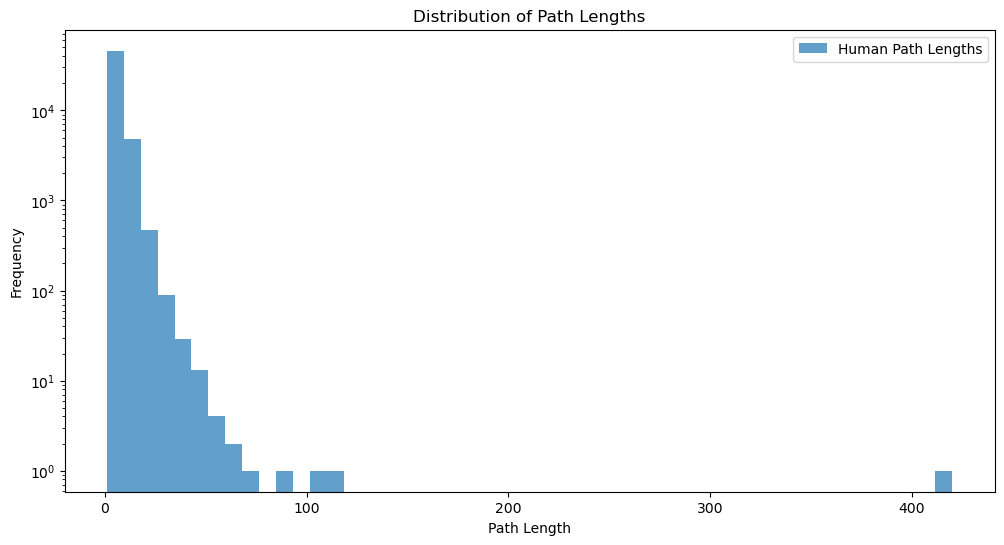

In [46]:
plt.figure(figsize=(12, 6))

# Plot human path lengths
plt.hist(paths_df["path_length"].dropna(), bins=50, alpha=0.7, label='Human Path Lengths')

# Add labels and title
plt.xlabel("Path Length")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Path Lengths")
plt.legend(loc='upper right')

# Show the plot
plt.show()

In [42]:
# Get the optimal path length

shortest_path_matrix = dict(nx.all_pairs_shortest_path_length(G))

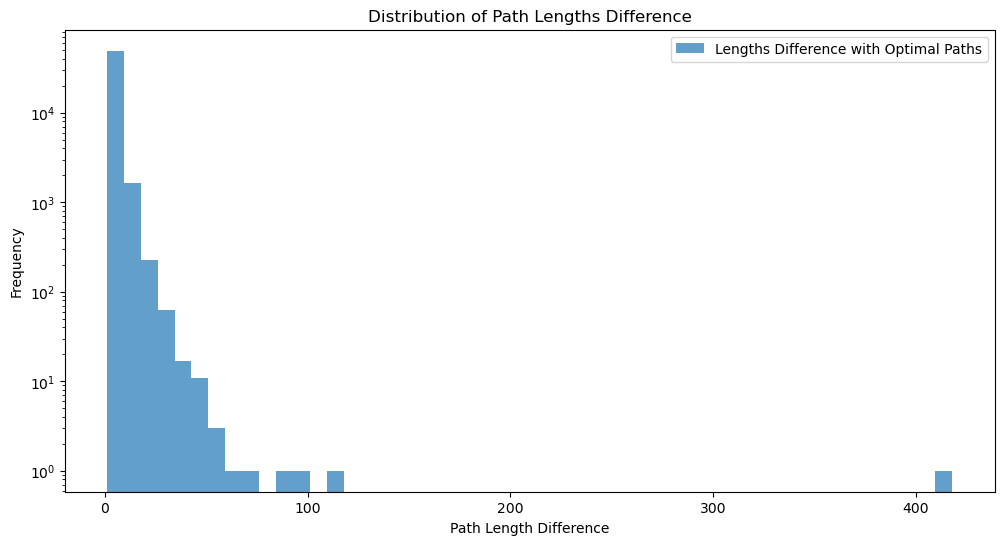

In [45]:
import numpy as np

def calculate_shortest_path_length(path):
    articles = path.split(';')
    start_article = articles[0]
    end_article = articles[-1]
    if start_article != end_article:
        try:
            return shortest_path_matrix[start_article][end_article]
        except KeyError:
            return np.nan 
    return 0  

paths_df["shortest_path_length"] = paths_df["path"].apply(calculate_shortest_path_length)
paths_df["path_length_difference"] = paths_df["path_length"] - paths_df["shortest_path_length"]

plt.figure(figsize=(12, 6))

# Plot human path lengths
plt.hist(paths_df["path_length_difference"].dropna(), bins=50, alpha=0.7, label='Lengths Difference with Optimal Paths')

# Add labels and title
plt.xlabel("Path Length Difference")
plt.ylabel("Frequency")
plt.yscale("log")
plt.title("Distribution of Path Lengths Difference")
plt.legend(loc='upper right')

# Show the plot
plt.show()